In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
!pip install matplotlib

In [3]:
# Import required libraries
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import matplotlib.pyplot as plt

# Load the SST2 dataset
dataset = load_dataset("glue", "sst2")

# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, RobertaForSequenceClassification
from datasets import DatasetDict
from transformers import EarlyStoppingCallback
from transformers.trainer_callback import TrainerCallback
# Preprocess the dataset (tokenization and padding)
def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [5]:
# Optional: Reduce the dataset size to speed up training
small_train = encoded_dataset['train'].shuffle(seed=42).select([i for i in range(5000)])  # Change this value for faster training
small_eval = encoded_dataset['validation'].shuffle(seed=42).select([i for i in range(872)])
small_test = encoded_dataset['train'].shuffle(seed=42).select([i for i in range(5000, 6000)])


In [6]:
# Create a custom callback to store accuracy for each epoch
class AccuracyCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_result = trainer.predict(small_train)
        train_acc = compute_metrics(train_result)['accuracy']
        eval_result = trainer.evaluate()
        eval_acc = eval_result['eval_accuracy']

        self.train_accuracies.append(train_acc)
        self.eval_accuracies.append(eval_acc)

        print(f"Epoch {state.epoch} - Train Accuracy: {train_acc:.4f}, Eval Accuracy: {eval_acc:.4f}")

# Initialize the callback
accuracy_callback = AccuracyCallback()

In [9]:
# Load the RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Define the training arguments (including the changes)
training_args = TrainingArguments(
    output_dir="./results",               # Output directory
    eval_strategy="epoch",                # Evaluation strategy
    save_strategy="epoch",                # Save strategy
    num_train_epochs=3,                   # Reduced epochs for faster training
    per_device_train_batch_size=8,        # Smaller batch size for training
    per_device_eval_batch_size=8,         # Smaller batch size for evaluation
    weight_decay=0.01,                    # Regularization
    load_best_model_at_end=True,          # Load the best model at the end of training
    save_total_limit=2,                   # Limit the number of saved checkpoints
    fp16=True,                            # Mixed precision for faster training (if supported by GPU)
    logging_dir="./logs",                 # Directory for logging
    logging_steps=100                     # Log every 100 steps
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The model to train
    args=training_args,                  # Training arguments defined above
    train_dataset=small_train,           # Reduced training set
    eval_dataset=small_eval,             # Reduced validation set
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics
    compute_metrics=lambda p:{'accuracy': np.mean(np.argmax(p.predictions, axis=1) == p.label_ids)},
    callbacks=[accuracy_callback]
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:

# Function to compute accuracy
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    preds = np.argmax(logits, axis=1)
    accuracy = np.mean(preds == labels)
    return {'accuracy': accuracy}

In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.469800,0.309746,0.876147
2,0.399600,0.379005,0.899083
3,0.215400,0.373191,0.911697


Epoch 1.0 - Train Accuracy: 0.9092, Eval Accuracy: 0.8761
Epoch 2.0 - Train Accuracy: 0.9536, Eval Accuracy: 0.8991
Epoch 3.0 - Train Accuracy: 0.9762, Eval Accuracy: 0.9117


TrainOutput(global_step=1875, training_loss=0.35326422424316406, metrics={'train_runtime': 4273.7385, 'train_samples_per_second': 3.51, 'train_steps_per_second': 0.439, 'total_flos': 491010451514400.0, 'train_loss': 0.35326422424316406, 'epoch': 3.0})

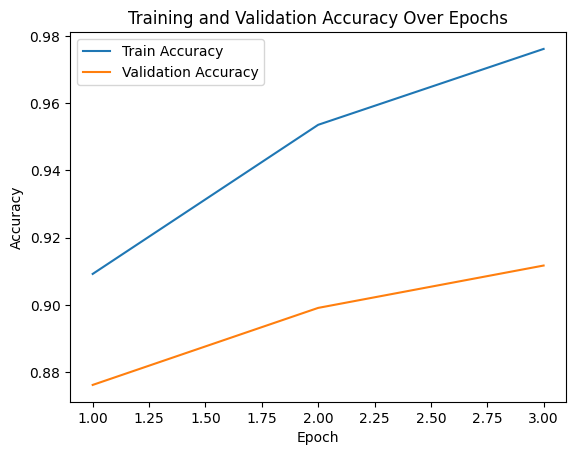

Test Accuracy: 0.911697247706422


In [12]:
# After training, plot the accuracies
epochs = list(range(1, training_args.num_train_epochs + 1))
plt.plot(epochs, accuracy_callback.train_accuracies, label="Train Accuracy")
plt.plot(epochs, accuracy_callback.eval_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.show()

# Test set evaluation
test_result = trainer.predict(small_eval)
test_acc = np.mean(np.argmax(test_result.predictions, axis=1) == test_result.label_ids)
print(f"Test Accuracy: {test_acc}")

In [ ]:
# # Train the model
# train_result = trainer.train()

# # Evaluate the model on validation set
# eval_result = trainer.evaluate()

# # Save the training and validation metrics
# trainer.save_metrics("train", train_result.metrics)
# trainer.save_metrics("eval", eval_result)

In [ ]:
# # Test set evaluation
# test_result = trainer.predict(small_test)
# test_acc = np.mean(np.argmax(test_result.predictions, axis=1) == test_result.label_ids)

# print(f"Test Accuracy: {test_acc}")

In [ ]:
# # Plotting Accuracy on Train and Validation Sets
# train_accuracies = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]
# eval_accuracies = [log['train_accuracy'] for log in trainer.state.log_history if 'train_accuracy' in log]

# plt.figure(figsize=(8, 6))
# plt.plot(train_accuracies, label="Train Accuracy")
# plt.plot(eval_accuracies, label="Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Training vs Validation Accuracy")
# plt.legend()
# plt.savefig("accuracy_plot.png")
# plt.show()

# # Report results on the test set corresponding to the best model
# print(f"Best Validation Accuracy: {max(eval_accuracies)}")
# print(f"Test Set Accuracy: {test_acc}")

# # Save your model
# trainer.save_model("./best_model")